In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import json
from collections import defaultdict
import os

### Stereotyping in NYT Book Opinions

In [23]:
with open('{}/../results/human_annotations/all_q_ID_to_TV.json'.format(os.getcwd()), 'r') as json_file:
    all_qID_to_TV = json.load(json_file)

def get_qID_to_tv(data):
    all_values = np.zeros((len(list(data.keys())), 4))
    for i, qID in enumerate(list(data.keys())):
        all_values[i] = np.array(list(data[qID]['avg_actual_results'].values()))
    avg_values = list(all_values.mean(axis=0))
    return avg_values
        
## Average over models 

models = ['gpt-3.5-turbo-0125', 'gpt-4', 'anthropic_haiku', 'anthropic_opus', 'llama3-70b']
output_types = ['sequence', 'model_logprobs', 'express_distribution']

dem_to_group={'Democrat':"POLPARTY", 'Republican':"POLPARTY", 'Male':"SEX", 'Female':'SEX'}

output_type='express_distribution'
nosteer, persona, fewshot = defaultdict(list), defaultdict(list), defaultdict(list)
for dem in ['Democrat', 'Republican', 'Male', 'Female']:
    for model in models:
        # no steer
        with open('{}/../results/nytimes/{}/{}/task0/NONE/{}.json'.format(os.getcwd(),output_type,model, 'Democrat'), 'r') as json_file:
            data = json.load(json_file)

        nosteer[dem].append(get_qID_to_tv(data))

        # persona steer
        with open('{}/../results/nytimes/{}/{}/task1/{}/{}.json'.format(os.getcwd(),output_type,model, dem_to_group[dem], dem), 'r') as json_file:
            data = json.load(json_file)
        persona[dem].append(get_qID_to_tv(data))

        # few shot steer
        with open('{}/../results/nytimes/{}/{}/task3_easy_hard/{}/{}.json'.format(os.getcwd(),output_type,model, dem_to_group[dem], dem), 'r') as json_file:
            data = json.load(json_file)
        fewshot[dem].append(get_qID_to_tv(data))
    

In [24]:
def bootstrap(input_data):     
    bs = []

    for i in range (np.array(input_data).shape[1]):
        data = list(np.array(input_data)[:, i])

        num_bootstraps = 1000

        def compute_statistic(sample):
            return np.mean(sample)  

        # Bootstrapping process
        bootstrap_statistics = []
        for _ in range(num_bootstraps):
            bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
            statistic = compute_statistic(bootstrap_sample)
            bootstrap_statistics.append(statistic)

        # 95% confidence interval
        confidence_level = 0.95
        alpha = (1 - confidence_level) / 2
        lower_percentile = alpha * 100
        upper_percentile = (1 - alpha) * 100
        lower_bound = np.percentile(bootstrap_statistics, lower_percentile)
        upper_bound = np.percentile(bootstrap_statistics, upper_percentile)
        
        bs.append((upper_bound-lower_bound)/2)

    return bs

# Function to take the average across axis 0 for each group
def average_across_axis0(data_dict):
    averaged_data = {group: np.mean(array, axis=0) for group, array in data_dict.items()}
    bs_data = {group: bootstrap(array) for group, array in data_dict.items()}
    return averaged_data, bs_data

# Calculate the averages
nosteer_avg, nosteer_bs = average_across_axis0(nosteer)
persona_avg, persona_bs = average_across_axis0(persona)
fewshot_avg, fewshot_bs = average_across_axis0(fewshot)



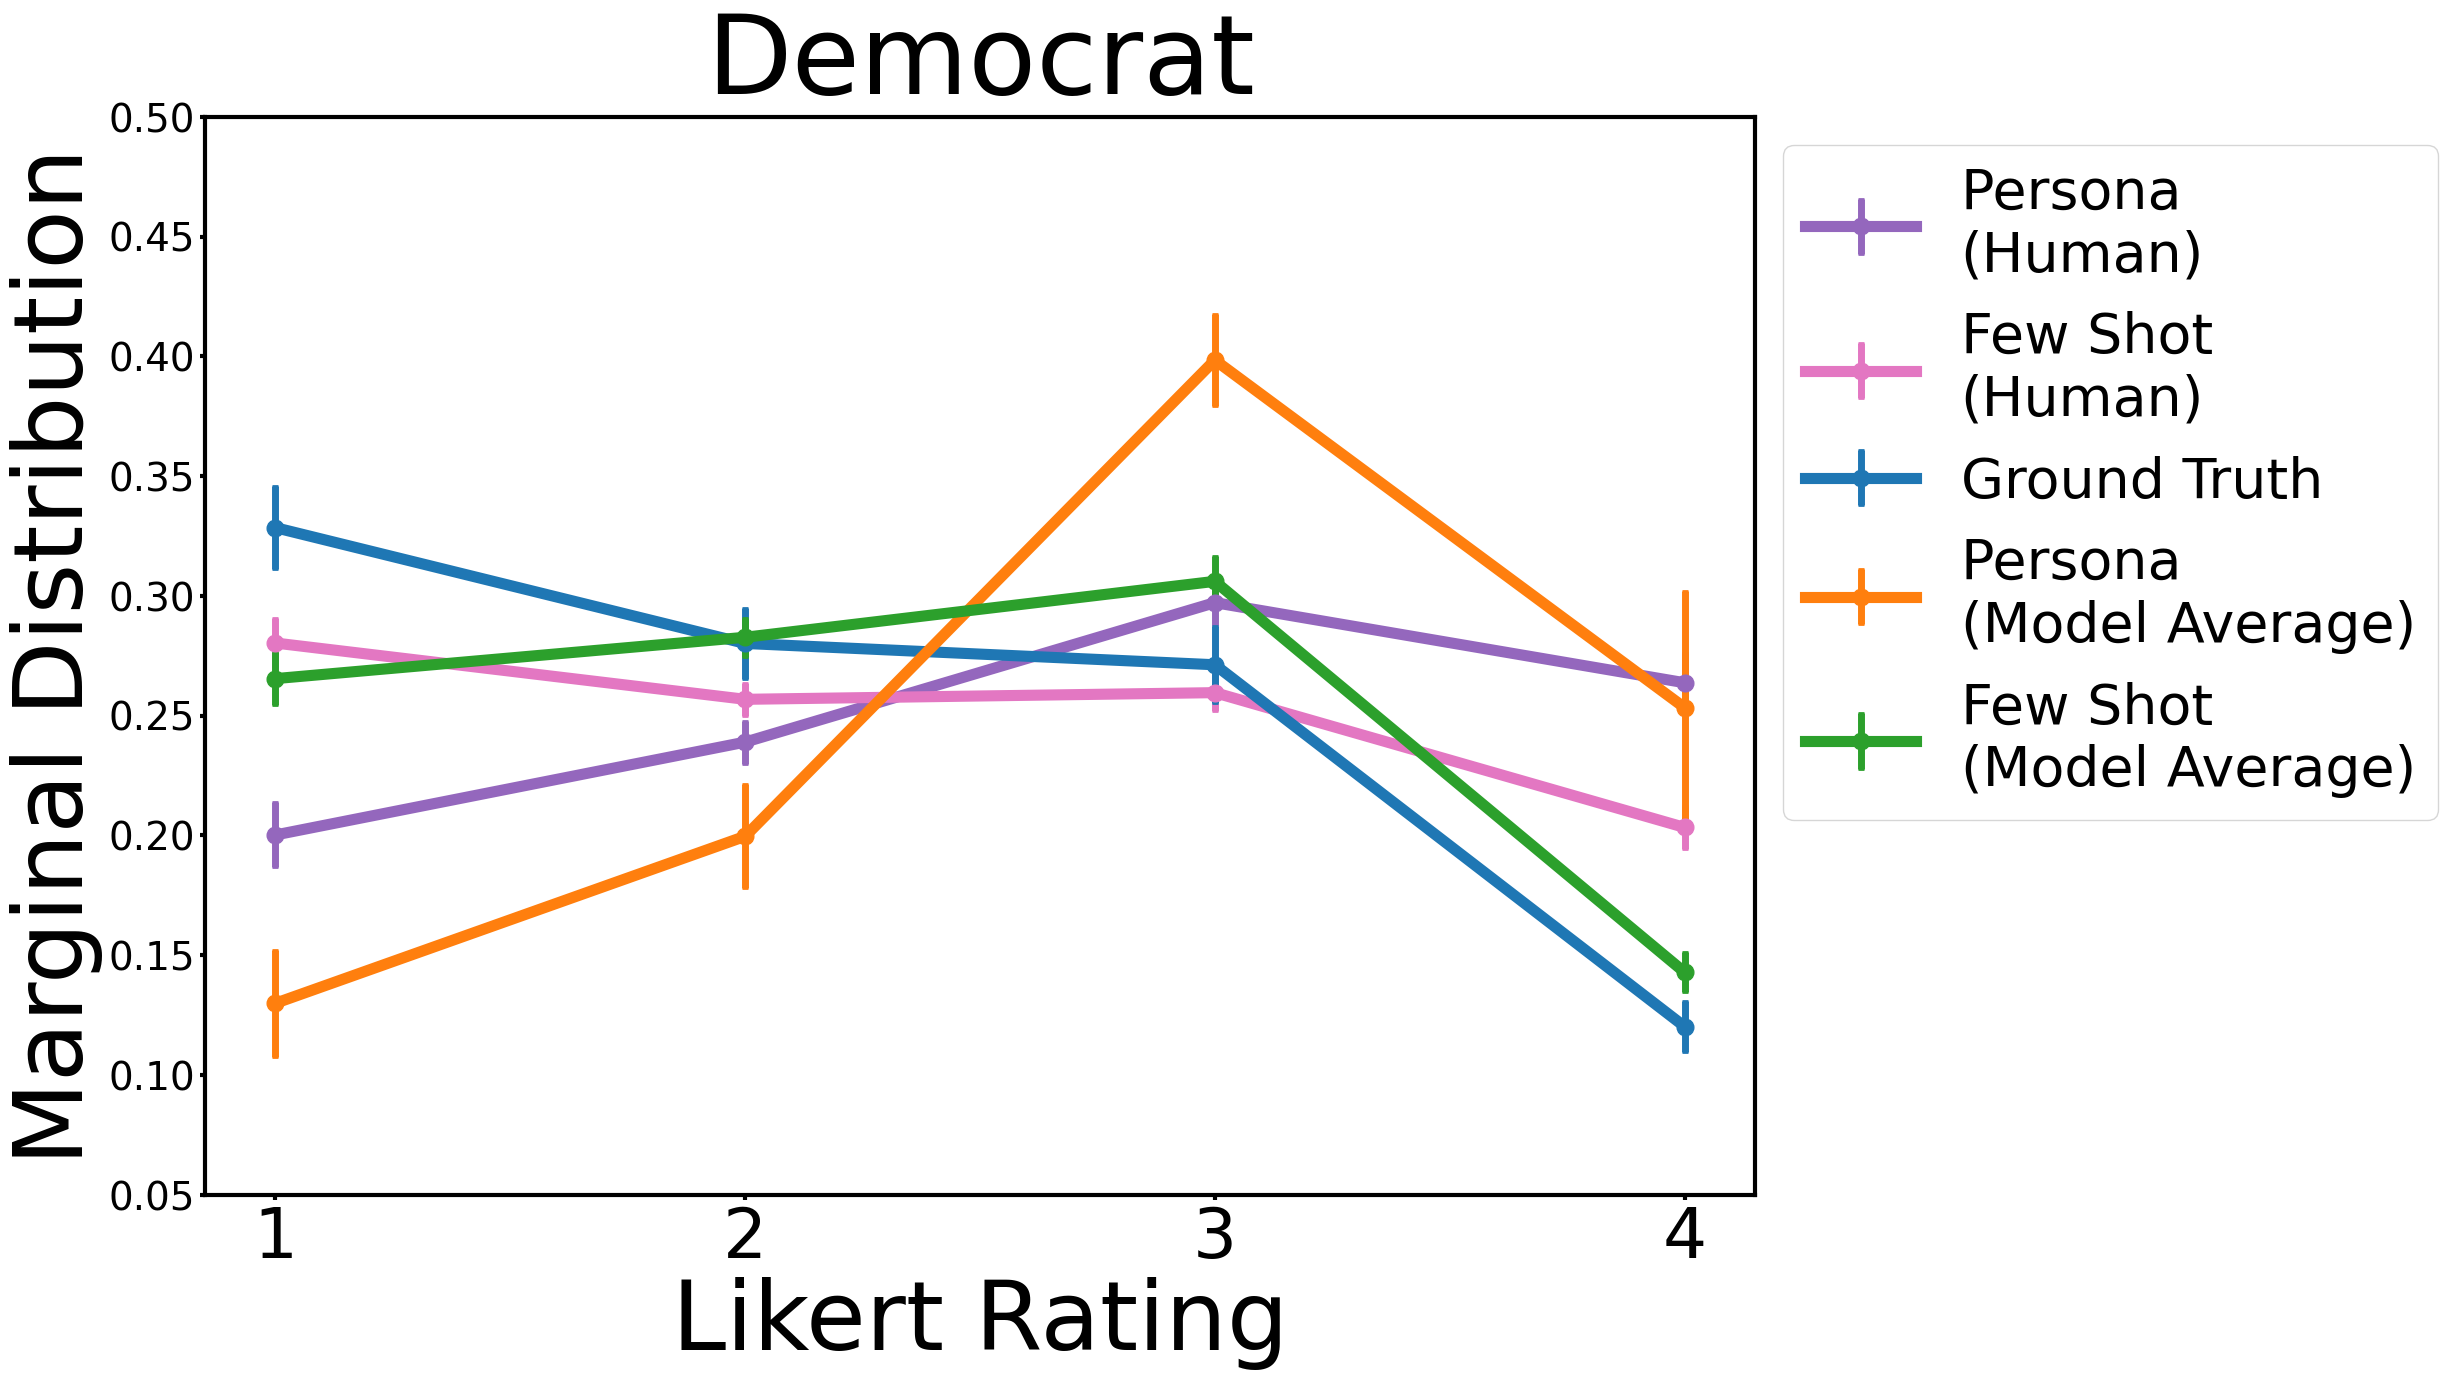

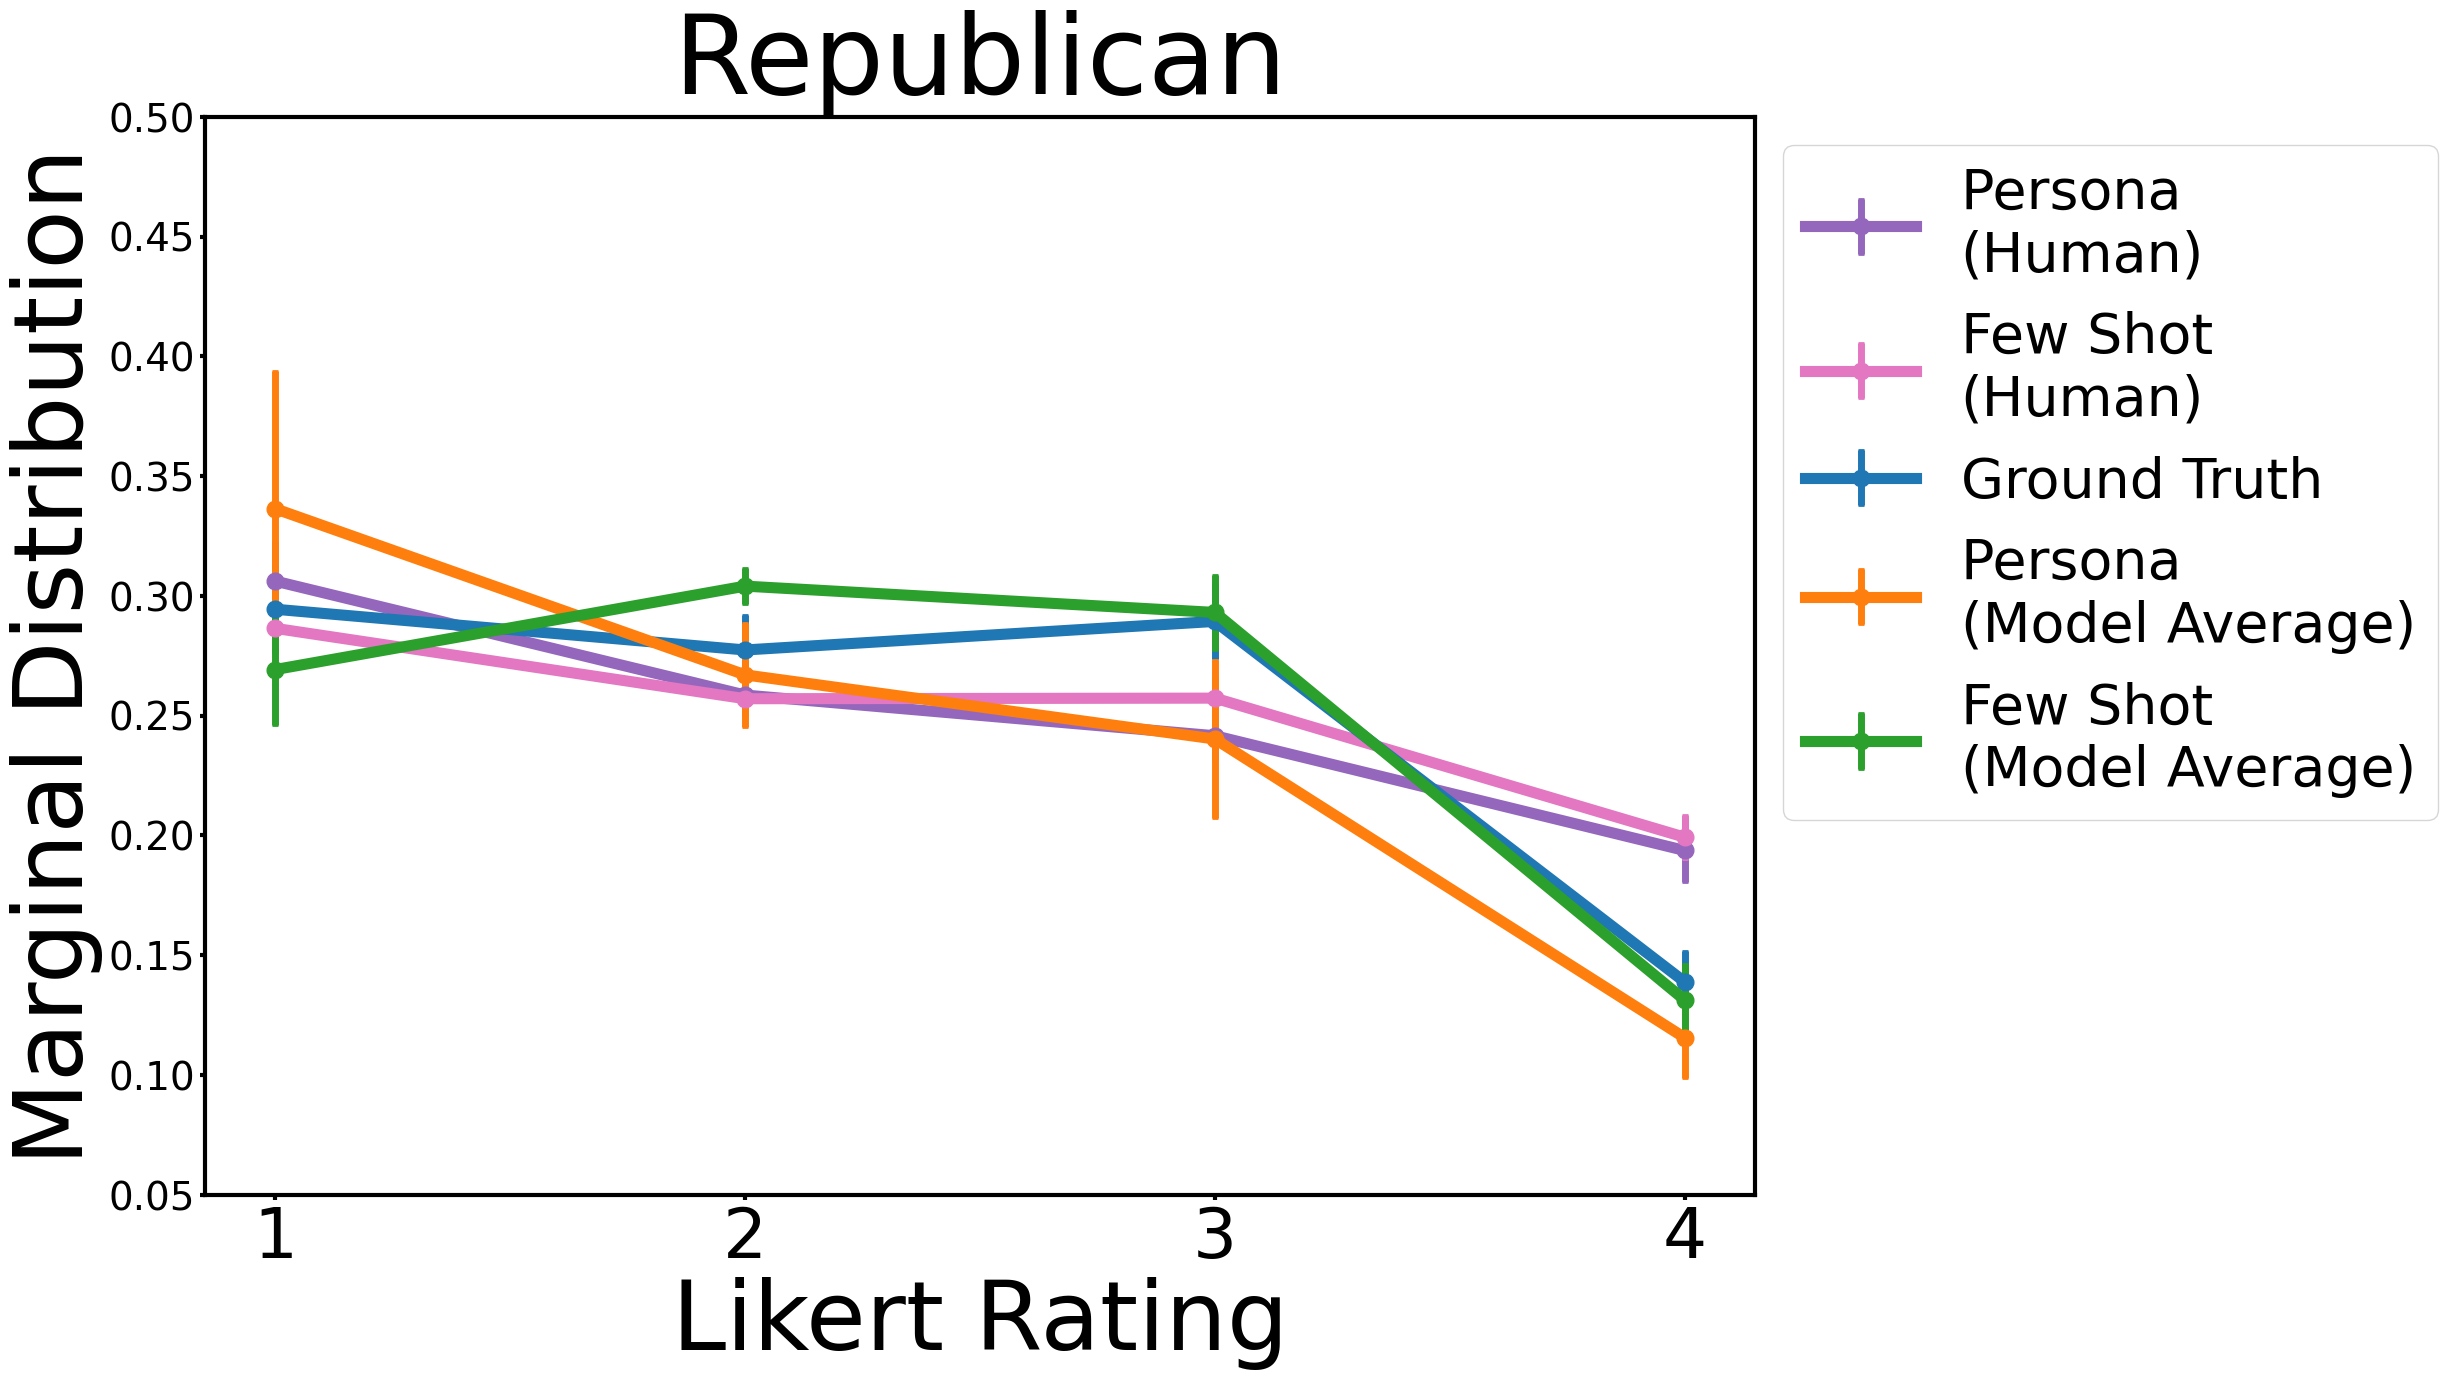

In [25]:
# Creating the line plot with error bars
labels = ['1', '2', '3', '4']

# Setting font sizes and scaling other parameters
scale_factor = 2
plt.rcParams.update({
    'font.size': 14 * scale_factor,          # Default text size
    'axes.titlesize': 16 * scale_factor,     # Axes title size
    'axes.labelsize': 16 * scale_factor,     # Axes label size
    'xtick.labelsize': 14 * scale_factor,    # X-tick label size
    'ytick.labelsize': 14 * scale_factor,    # Y-tick label size
    'legend.fontsize': 14 * scale_factor,    # Legend font size
    'figure.titlesize': 18 * scale_factor    # Figure title size
})



# for output_type in output_types:
#     for dem in ['Democrat', 'Republican']:

for output_type in ['express_distribution']:
    for dem in ['Democrat', 'Republican']:
        plt.figure(figsize=(10*scale_factor, 7*scale_factor))
        plt.xticks(fontsize=25*scale_factor)

        plt.tick_params(axis='x', width=3)  # Change 'width' to desired value
        plt.tick_params(axis='y', width=3)  # Change 'width' to desired value

        # humans
        # plt.errorbar(labels, all_qID_to_TV['humans'][dem]['nosteer_avg'], yerr=all_qID_to_TV['humans'][dem]['nosteer_bs'], label='No Steer \n(Human)', fmt='-o', ecolor='black', capsize=5, linestyle='-', linewidth=2*scale_factor,marker='o', markersize=6 * scale_factor)
        plt.errorbar(labels, all_qID_to_TV['humans'][dem]['persona_avg'], yerr=all_qID_to_TV['humans'][dem]['persona_bs'], label='Persona \n(Human)', ecolor='tab:purple', color='tab:purple', capsize=2, capthick=2, elinewidth=5, linestyle='-', marker='o', linewidth=4*scale_factor,markersize=6 * scale_factor)
        plt.errorbar(labels, all_qID_to_TV['humans'][dem]['fewshot_avg'], yerr=all_qID_to_TV['humans'][dem]['fewshot_bs'], label='Few Shot \n(Human)', ecolor='tab:pink', capsize=2, capthick=2, elinewidth=5, linestyle='-', marker='o', linewidth=4*scale_factor, markersize=6 * scale_factor, color='tab:pink', )
        plt.errorbar(labels, all_qID_to_TV['humans'][dem]['gt_avg'], yerr=all_qID_to_TV['humans'][dem]['gt_bs'], label='Ground Truth', ecolor='tab:blue', capsize=2, capthick=2, elinewidth=5, linestyle='-', marker='o', linewidth=4*scale_factor, color='tab:blue', markersize=6 * scale_factor)

        plt.errorbar(labels, persona_avg[dem], yerr=persona_bs[dem], label='Persona \n(Model Average)', ecolor='tab:orange', capsize=2, capthick=2, elinewidth=5, linestyle='-', marker='o', linewidth=4*scale_factor, color='tab:orange', markersize=6 * scale_factor)
        plt.errorbar(labels, fewshot_avg[dem], yerr=fewshot_bs[dem], label='Few Shot \n(Model Average)', ecolor='tab:green', capsize=2, capthick=2, elinewidth=5, linestyle='-', marker='o', linewidth=4*scale_factor, color='tab:green', markersize=6 * scale_factor)


        # Adding title and labels
        plt.title('{}'.format(dem), fontsize=scale_factor*40)
        plt.xlabel('Likert Rating', fontsize=scale_factor*35)
        plt.ylabel('Marginal Distribution', fontsize=scale_factor*35)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=scale_factor*20)

        plt.ylim([0.05, 0.5])

        
        # Change the plot bounding box thickness
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_linewidth(1.5*scale_factor)


        # Display the chart
        plt.show()


### NYT Book Opinion Disagreement

In [12]:
# read in data_nums.json
data_nums = json.load(open('{}/../results/human_annotations/data_nums.json'.format(os.getcwd())))

dem_data_nums = data_nums['dem_data_nums']
repub_data_nums = data_nums['repub_data_nums']
male_data_nums = data_nums['male_data_nums']
female_data_nums = data_nums['female_data_nums']
booktitles = data_nums['booktitles']
summaries = data_nums['summaries']

In [13]:
def get_bootstrapping_errors(input_data):     
    data = list(input_data)

    # Number of bootstrap samples
    num_bootstraps = 1000

    # Function to compute the statistic of interest (mean, median, etc.)
    def compute_statistic(sample):
        return np.mean(sample)  # Example: computing the mean

    # Bootstrapping process
    bootstrap_statistics = []
    for _ in range(num_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        statistic = compute_statistic(bootstrap_sample)
        bootstrap_statistics.append(statistic)

    # Compute confidence interval (e.g., 95% confidence interval)
    confidence_level = 0.95
    alpha = (1 - confidence_level) / 2
    lower_percentile = alpha * 100
    upper_percentile = (1 - alpha) * 100
    lower_bound = np.percentile(bootstrap_statistics, lower_percentile)
    upper_bound = np.percentile(bootstrap_statistics, upper_percentile)

    bs_error = (upper_bound-lower_bound)/2

    return bs_error


In [14]:
repub_means, repub_errors, dem_means, dem_errors = [], [], [], []
male_means, male_errors, female_means, female_errors = [], [], [], []

for repub_value in repub_data_nums: 
    repub_means.append(np.mean(repub_value))
    repub_errors.append(get_bootstrapping_errors(repub_value))

for dem_value in dem_data_nums: 
    dem_means.append(np.mean(dem_value))
    dem_errors.append(get_bootstrapping_errors(dem_value))

for male_value in male_data_nums: 
    male_means.append(np.mean(male_value))
    male_errors.append(get_bootstrapping_errors(male_value))

for female_value in female_data_nums: 
    female_means.append(np.mean(female_value))
    female_errors.append(get_bootstrapping_errors(female_value))

repub_means=np.array(repub_means)
repub_errors=np.array(repub_errors)
dem_means=np.array(dem_means)
dem_errors = np.array(dem_errors)

male_means=np.array(male_means)
male_errors = np.array(male_errors)

female_means=np.array(female_means)
female_errors = np.array(female_errors)

# repub_means = repub_data_nums.mean(axis=1)
# repub_errors = repub_data_nums.std(axis=1)  
# dem_means = dem_data_nums.mean(axis=1)
# dem_errors = dem_data_nums.std(axis=1)  

In [15]:
max_ind, min_ind = np.argmax(repub_means - dem_means), np.argmin(repub_means - dem_means)
max_ind, min_ind = np.argsort(repub_means - dem_means)[-5:][::-1], np.argsort(repub_means - dem_means)[:5][::-1]

print("MAX REPUB-DEM")
for i in max_ind:
    print('Max(Repub-Dem): {}\nBook Title: {}\n Book Summary: {}'.format((repub_means - dem_means)[i], booktitles[i], summaries[i]))
print("MIN REPUB-DEM")
for i in min_ind:
    print('Min(Repub-Dem): {}\nBook Title: {}\n Book Summary: {}'.format((repub_means - dem_means)[i], booktitles[i], summaries[i]))

max_ind, min_ind = np.argmax(male_means - female_means), np.argmin(male_means - female_means)
max_ind, min_ind = np.argsort(male_means - female_means)[-5:][::-1], np.argsort(male_means - female_means)[:5][::-1]

print("MAX MALE-FEMALE")
for i in max_ind:
    print('Max(Male-Female): {}\nBook Title: {}\n Book Summary: {}'.format((male_means - female_means)[i], booktitles[i], summaries[i]))
print("MIN MALE-FEMALE")
for i in min_ind:
    print('Min(Male-Female): {}\nBook Title: {}\n Book Summary: {}'.format((male_means - female_means)[i], booktitles[i], summaries[i]))

MAX REPUB-DEM
Max(Repub-Dem): 1.263157894736842
Book Title: Redeployment By Phil Klay
 Book Summary: Twelve stories by a former Marine who served in Iraq capture on an intimate scale the ways in which the war there evoked a unique array of emotion, predicament and heartbreak.
Max(Repub-Dem): 1.1549707602339183
Book Title: Washington'S Crossing By David Hackett Fischer
 Book Summary: how a daring venture across the Delaware on Christmas night 1776 defeated the British at Trenton and changed the dynamic of the Revolutionary War.
Max(Repub-Dem): 1.0935672514619883
Book Title: Eastbound By Maylis De Kerangal
 Book Summary: In de Kerangal’s brief, lyrical novel, translated by Jessica Moore, a young Russian soldier on a trans-Siberian train decides to desert and turns to a civilian passenger, a Frenchwoman, for help.
Max(Repub-Dem): 1.05
Book Title: The Story Of The Lost Child By Elena Ferrante
 Book Summary: Friends confront age and the questions of life’s meaning in the stunning final book

In [16]:
max_ind, min_ind = np.argmax(repub_means - dem_means), np.argmin(repub_means - dem_means)

max_ind, min_ind = np.argsort(repub_means - dem_means)[-4:][::-1], np.argsort(repub_means - dem_means)[:4][::-1]

dem_plot_means, repub_plot_means, dem_plot_std, repub_plot_std, booktitles_plot  = [], [], [], [], []
for i in max_ind:
    print('Max(Repub-Dem): {}\nBook Title: {}\n Book Summary: {}'.format((repub_means - dem_means)[i], booktitles[i], summaries[i]))
    dem_plot_means.append(dem_means[i])
    dem_plot_std.append(dem_errors[i])
    repub_plot_means.append(repub_means[i])
    repub_plot_std.append(repub_errors[i])
    booktitles_plot.append(booktitles[i])
for i in min_ind:
    print('Min(Repub-Dem): {}\nBook Title: {}\n Book Summary: {}'.format((repub_means - dem_means)[i], booktitles[i], summaries[i]))
    dem_plot_means.append(dem_means[i])
    dem_plot_std.append(dem_errors[i])
    repub_plot_means.append(repub_means[i])
    repub_plot_std.append(repub_errors[i])
    booktitles_plot.append(booktitles[i])

Max(Repub-Dem): 1.263157894736842
Book Title: Redeployment By Phil Klay
 Book Summary: Twelve stories by a former Marine who served in Iraq capture on an intimate scale the ways in which the war there evoked a unique array of emotion, predicament and heartbreak.
Max(Repub-Dem): 1.1549707602339183
Book Title: Washington'S Crossing By David Hackett Fischer
 Book Summary: how a daring venture across the Delaware on Christmas night 1776 defeated the British at Trenton and changed the dynamic of the Revolutionary War.
Max(Repub-Dem): 1.0935672514619883
Book Title: Eastbound By Maylis De Kerangal
 Book Summary: In de Kerangal’s brief, lyrical novel, translated by Jessica Moore, a young Russian soldier on a trans-Siberian train decides to desert and turns to a civilian passenger, a Frenchwoman, for help.
Max(Repub-Dem): 1.05
Book Title: The Story Of The Lost Child By Elena Ferrante
 Book Summary: Friends confront age and the questions of life’s meaning in the stunning final book of this brill

In [17]:
labels = ['Redeployment \n by P. Klay',
 "Washington's \n Crossing \n by D.H. Fischer",
 'Eastbound \n by M. Kerangal',
 'The Story Of \nThe Lost Child \n by E. Ferrante',
#  'The Fraud \n by Zadie Smith',
#  'White Teeth \n by Zadie Smith',
 'A Promised Land \n by B. Obama',
 'A Short History\n Of Women \n by K. Walbert',
 'Ten Thousand\n Saints \n by \n E. Henderson',
 'Nw \n by Z. Smith']

In [18]:
# Setting font sizes and scaling other parameters
scale_factor = 2
plt.rcParams.update({
    'font.size': 18 * scale_factor,          # Default text size
    'axes.titlesize': 16 * scale_factor,     # Axes title size
    'axes.labelsize': 22 * scale_factor,     # Axes label size
    'xtick.labelsize': 24 * scale_factor,    # X-tick label size
    'ytick.labelsize': 14 * scale_factor,    # Y-tick label size
    'legend.fontsize': 22 * scale_factor,    # Legend font size
    'figure.titlesize': 18 * scale_factor    # Figure title size
})


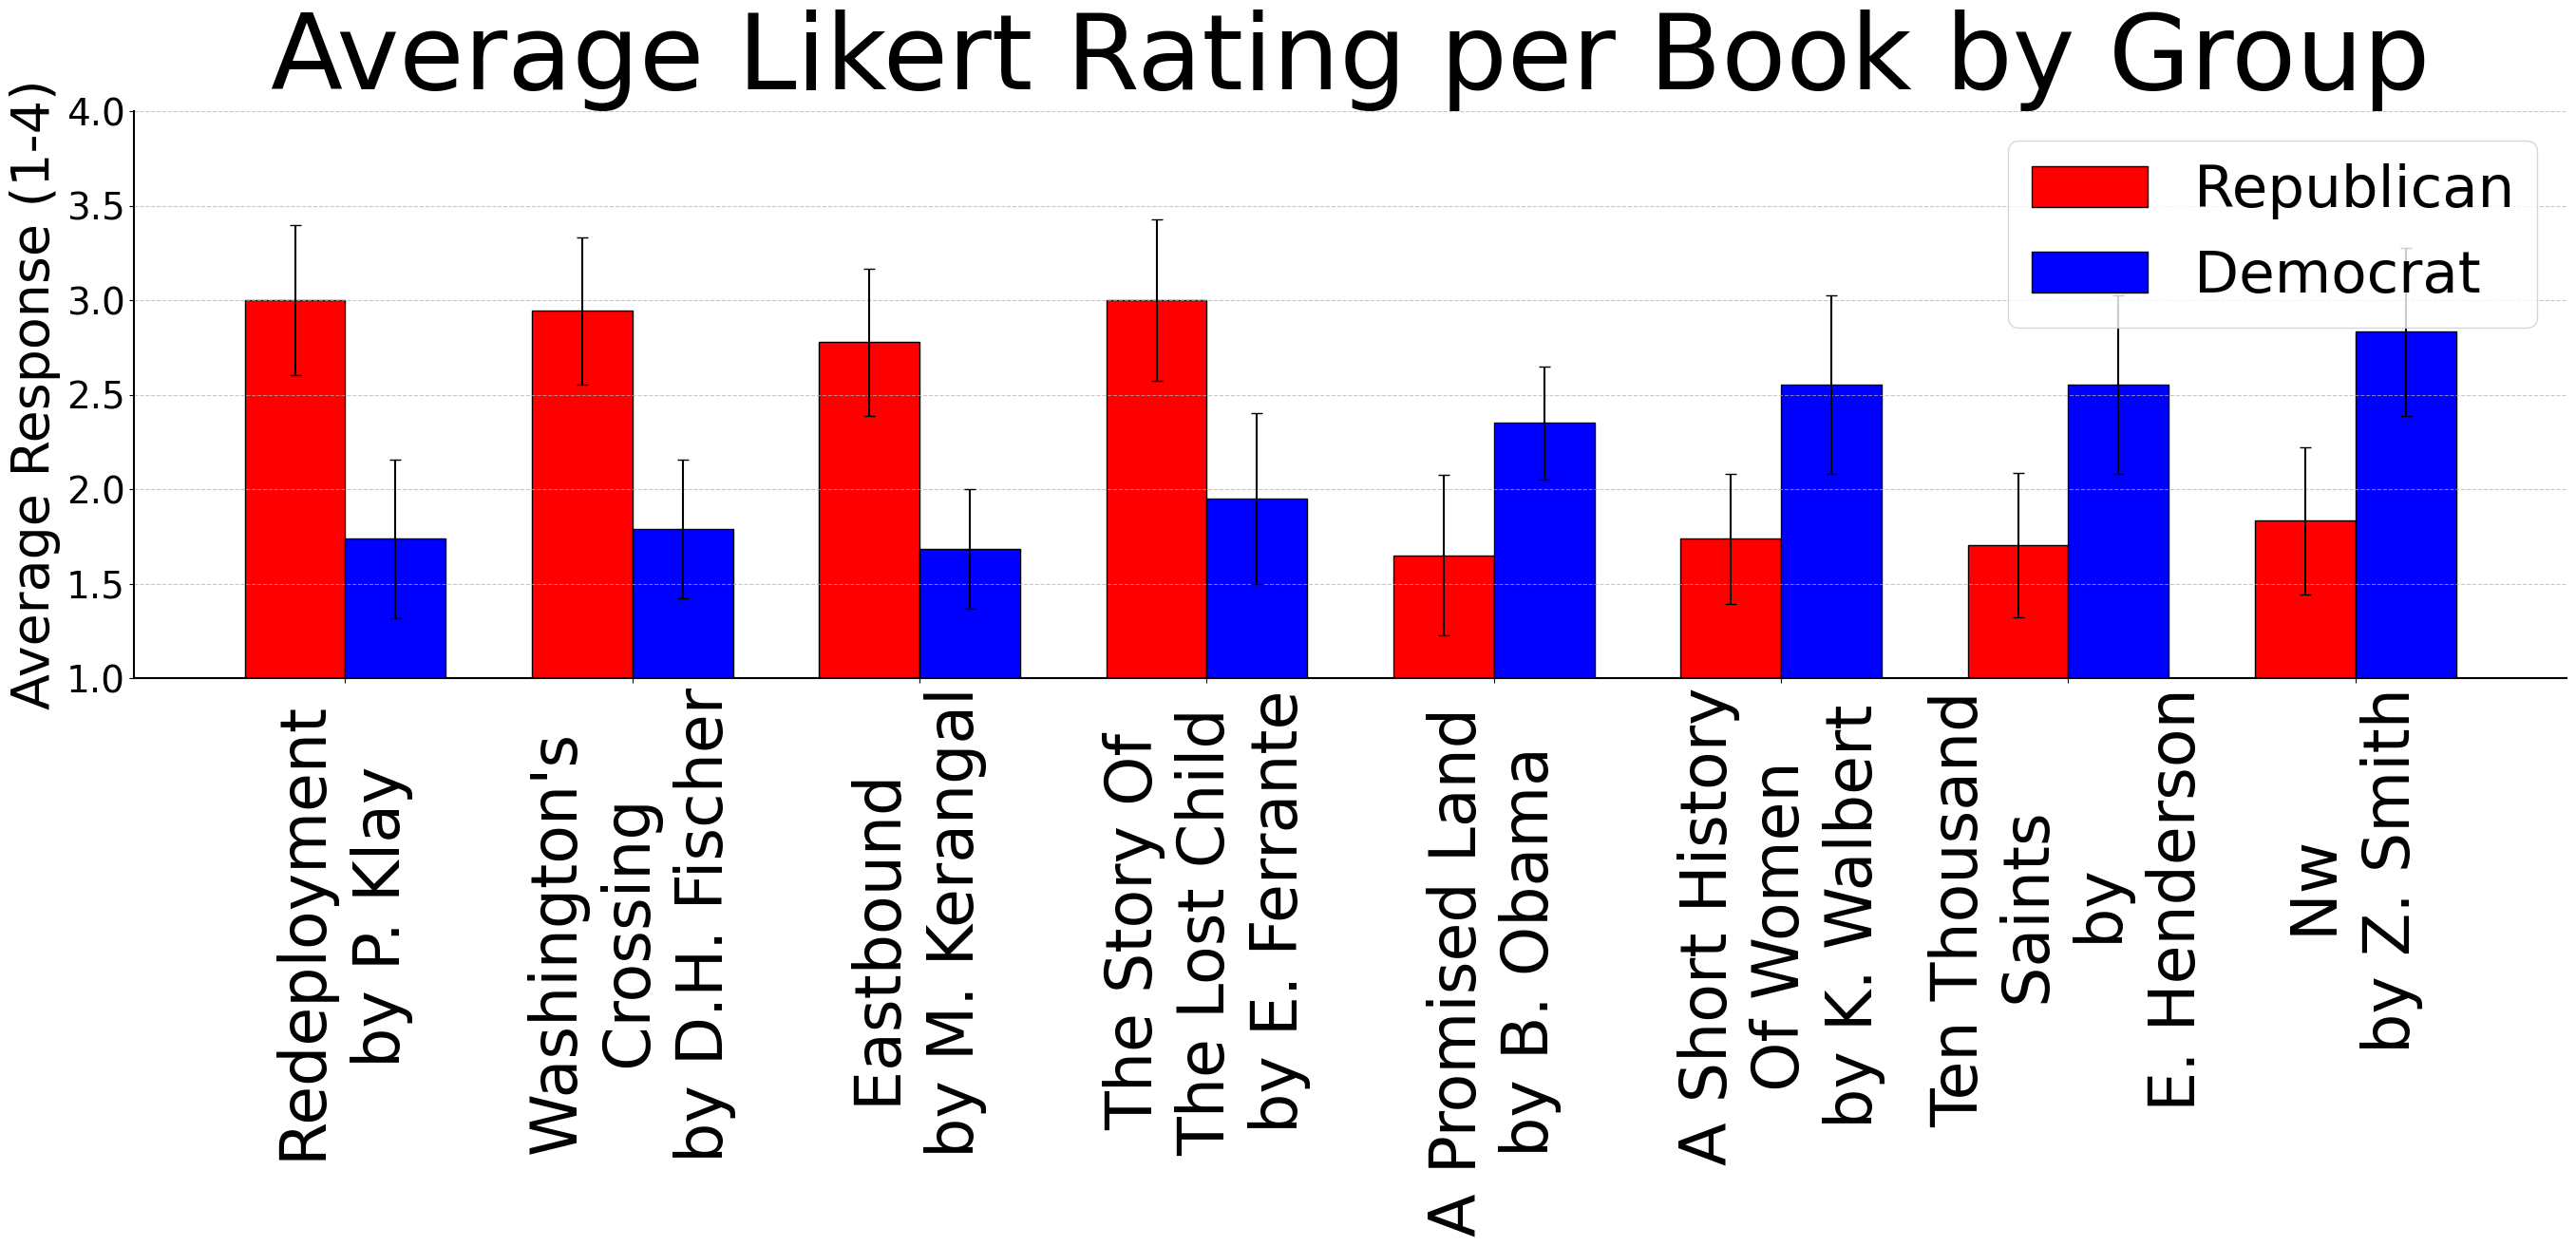

In [19]:
# labels = booktitles_plot

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14*scale_factor, 7*scale_factor))

# Plotting group 1 bars
bars1 = ax.bar(x - width/2, repub_plot_means, width, yerr=repub_plot_std, capsize=4, label='Republican', color='red', edgecolor='black')

# Plotting group 2 bars
bars2 = ax.bar(x + width/2, dem_plot_means, width, yerr=dem_plot_std, capsize=4, label='Democrat', color='blue', edgecolor='black')

# Adding labels, title, and custom x-axis tick labels
# ax.set_xlabel('Books', fontsize=22*scale_factor)
ax.set_ylabel('Average Response (1-4)', fontsize=20*scale_factor)
ax.set_title('Average Likert Rating per Book by Group', fontsize=40*scale_factor)
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.tick_params(axis='x', rotation=90)

ax.set_ylim([1, 4])
ax.legend()

# Adding a grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Improving the layout
plt.tight_layout()
# Removing the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjusting the bottom and left spines
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)


# Displaying the plot
plt.tight_layout()
plt.xticks()
plt.show()

### Biased Coin Flip 

In [7]:
path = '{}/../results/'.format(os.getcwd())

key_to_color= {'h': 'b', 't': 'g'}
key_to_name = {'h': 'Heads', 't': 'Tails'}
# Setting font sizes and scaling other parameters
scale_factor = 2
plt.rcParams.update({
    'font.size': 18 * scale_factor,          # Default text size
    'axes.titlesize': 16 * scale_factor,     # Axes title size
    'axes.labelsize': 22 * scale_factor,     # Axes label size
    'xtick.labelsize': 14 * scale_factor,    # X-tick label size
    'ytick.labelsize': 14 * scale_factor,    # Y-tick label size
    'legend.fontsize': 22 * scale_factor,    # Legend font size
    'figure.titlesize': 18 * scale_factor    # Figure title size
})

gpt-4


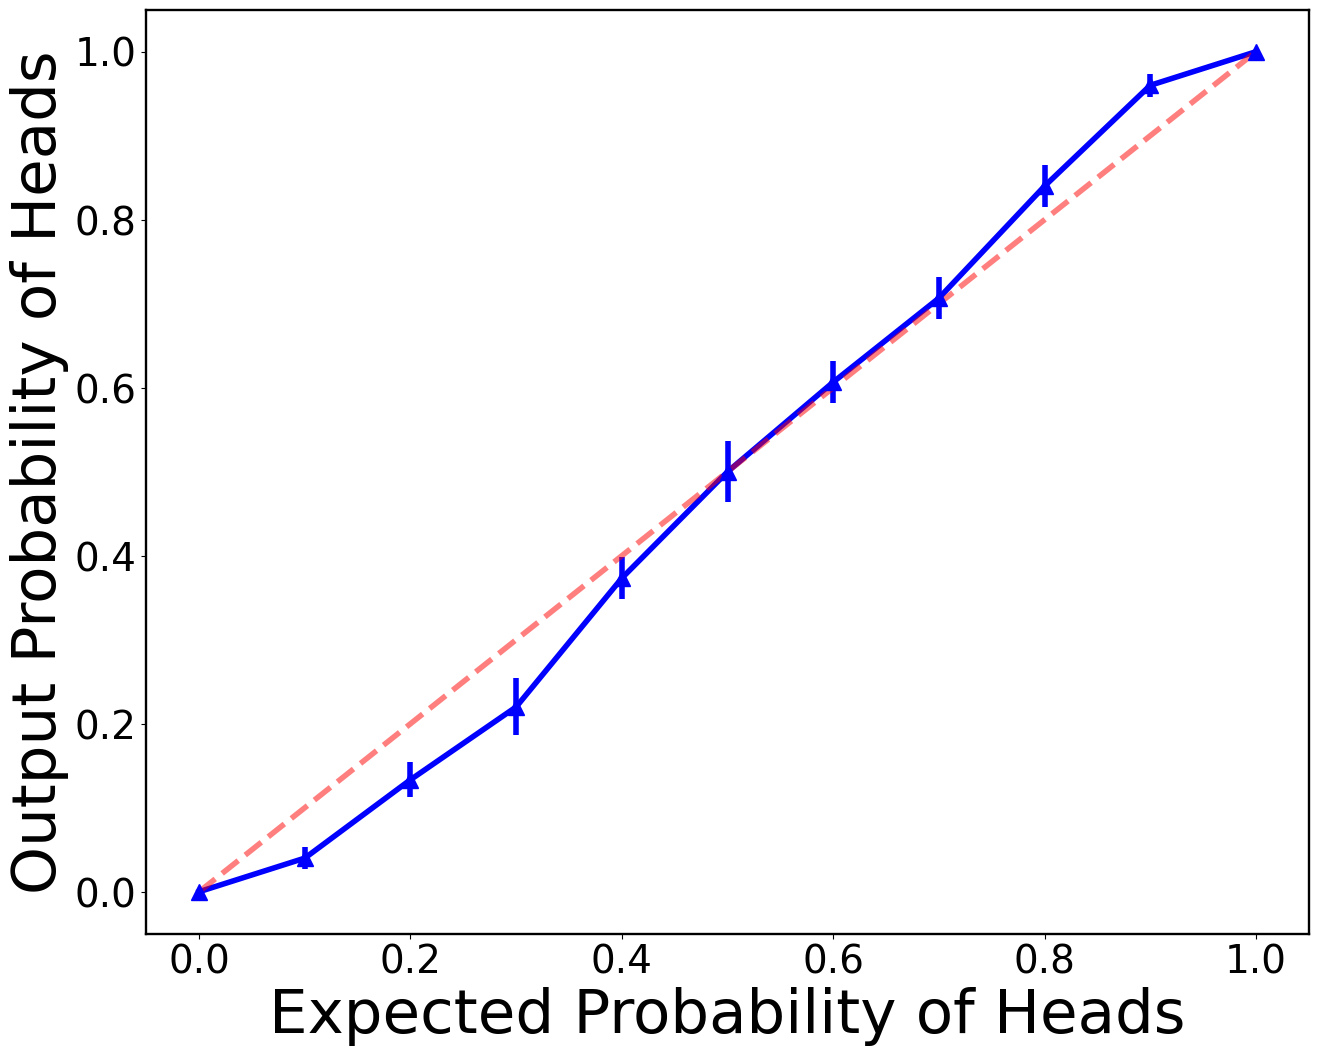

In [8]:
#### SEQUENCE
models = ['gpt-4']

plt.figure(figsize=(15, 12))  # Double the size of the figure


for model in models:
  print(model)
  # load data
  with open(path +"/biased_coin/"+ model + '/biased_coin_seq_benchmark.json', 'r') as file:
    # Load JSON data into a dictionary
    data = json.load(file)

  expected, actual_all, expected_all, actual_mean, actual_std = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)

  for i, question in enumerate(list(data.keys())):

    expected_results = data[question]['expected_results']
    actual_results = data[question]['actual_results']
    
    avg_expected_results = data[question]['avg_expected_results']
    std_expected_results = data[question]['std_expected_results']

    # if actual results has any [], fill it with zeros 
    for key in list(actual_results.keys()):
      if not actual_results[key]:
          actual_results[key] = list(np.zeros(5))
          avg_expected_results[key] = 0
          std_expected_results[key] = 0
    # Expand expected results to the size of actual results 
    for key in list(expected_results.keys()):
      expected_results[key] = list(expected_results[key] * np.ones(len(actual_results[key])))
    
    for key in list(expected_results.keys()):
      expected_all[key]+=expected_results[key]
      actual_all[key]+=actual_results[key]

      expected[key].append(expected_results[key][0])
      actual_mean[key].append(avg_expected_results[key])
      actual_std[key].append(std_expected_results[key])

  for key in list(expected_results.keys())[0]:
    plt.plot(expected[key], actual_mean[key], label=key_to_name[key], color=key_to_color[key], markersize=6 * scale_factor, linewidth=2 * scale_factor)
    plt.errorbar(expected[key], actual_mean[key], actual_std[key], linestyle='None', color=key_to_color[key], marker='^', markersize=6 * scale_factor, linewidth=2 * scale_factor)
    plt.xlabel("Expected Probability of Heads")
    plt.ylabel("Output Probability of Heads")
      
  x = np.linspace(0, 1, 100)
  plt.plot(x, x, 'r--', alpha=0.5, linewidth=2 * scale_factor)

  # Change the plot bounding box thickness
  ax = plt.gca()
  for spine in ax.spines.values():
      spine.set_linewidth(0.85*scale_factor)

  plt.show()



